In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow.python import keras

In [3]:
def file_len(filename):
    with open(filename) as f:
        for i, l in enumerate(f):
            pass
    return i

In [4]:
def file_read(path, numberOfRows):
    indexCounter = 0
    with open(path,'r') as file:
        nRows = numberOfRows
        nColumns = 4
        dataset = np.zeros(shape=(nRows, nColumns))
        times_arrival = []
        for line in file:
            try:
                dataInstance = line.split(',')
                time_arrival = dataInstance[1] #splits the line at the comma and takes the first bit
                time_arrival = dt.datetime.strptime(time_arrival, '%H:%M')
                hour_arrival = time_arrival.hour
                minute_arrival = time_arrival.minute
                waitingMinutes = dataInstance[2]
                serviceMinutes = dataInstance[3]

                times_arrival.append(time_arrival)
                dataset[indexCounter] = [hour_arrival, minute_arrival, waitingMinutes, serviceMinutes]
                indexCounter = indexCounter + 1
            except:
                #print('index' + str(indexCounter) + 'error')
                pass
    return dataset, times_arrival

In [5]:
filenames = []
rootFilePath = './PostOfficeDataCsv/'
completeDataset = pd.DataFrame()

for post_office in range(3):
    for week in range(4):
        if(post_office == 0 and week == 0):
            i = 2
        else:
            i = 0
            
        for day in range(i,5):
            filename = 'PostOffice' + str(post_office + 1) + 'Week' + str(week + 1) + 'Day' + str(day + 1)
            fullPath = rootFilePath + filename + '.csv'
            filenames.append(fullPath)
            
            numberOfRows = file_len(fullPath) - 1
            print ('Reading ' + filename + 'that contains' + str(numberOfRows) + ' entries')
            tempFeatures, tempArrivalTimes = file_read(rootFilePath + filename + '.csv', numberOfRows)
            dfTempFeatures = pd.DataFrame(np.array(tempFeatures), columns=['hour', 'minutes', 'waitingTime', 'serviceTime'])
            dfTempArrivalTimes = pd.DataFrame(np.array(tempArrivalTimes), columns=['arrivalTime'])
            
            timeLeavingTheQueue = []
            for arrivalTime in range(numberOfRows):
                timeLeavingTheQueue.append(dfTempArrivalTimes.at[arrivalTime, 'arrivalTime'] + pd.Timedelta(minutes = dfTempFeatures.at[arrivalTime, 'waitingTime']))
            dftimeLeavingTheQueue = pd.DataFrame(np.array(timeLeavingTheQueue), columns=['timeLeavingTheQueue'])

            waitingPeople = np.zeros(numberOfRows)
            for i in range(numberOfRows):
                for j in range(i):
                    if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheQueue.at[j, 'timeLeavingTheQueue']):
                        waitingPeople[i] += 1
            dfWaitingPeople = pd.DataFrame(np.array(waitingPeople), columns=['waitingPeople'])
            
            dayOfWeek = np.zeros(numberOfRows)
            for i in range(numberOfRows):
                dayOfWeek[i] = day
            dfDayOfWeek = pd.DataFrame(np.array(dayOfWeek), columns=['dayOfWeek'])
            
            dfWaitingPeople['waitingPeople'] = dfWaitingPeople['waitingPeople'].astype(int)
            dfTempFeatures['hour'] = dfTempFeatures['hour'].astype(int)
            dfTempFeatures['minutes'] = dfTempFeatures['minutes'].astype(int)
            dfDayOfWeek['dayOfWeek'] = dfDayOfWeek['dayOfWeek'].astype(int)
    
            tempDataset = pd.concat([dfTempFeatures, dfWaitingPeople, dfDayOfWeek], axis=1)
        
            completeDataset = pd.concat([completeDataset, tempDataset], axis=0)
          
completeDataset = completeDataset.reset_index(drop = True)
print(completeDataset.shape[0])

Reading PostOffice1Week1Day3that contains1019 entries
Reading PostOffice1Week1Day4that contains801 entries
Reading PostOffice1Week1Day5that contains521 entries
Reading PostOffice1Week2Day1that contains988 entries
Reading PostOffice1Week2Day2that contains683 entries
Reading PostOffice1Week2Day3that contains547 entries
Reading PostOffice1Week2Day4that contains1020 entries
Reading PostOffice1Week2Day5that contains788 entries
Reading PostOffice1Week3Day1that contains999 entries
Reading PostOffice1Week3Day2that contains989 entries
Reading PostOffice1Week3Day3that contains1000 entries
Reading PostOffice1Week3Day4that contains1050 entries
Reading PostOffice1Week3Day5that contains981 entries
Reading PostOffice1Week4Day1that contains856 entries
Reading PostOffice1Week4Day2that contains980 entries
Reading PostOffice1Week4Day3that contains1056 entries
Reading PostOffice1Week4Day4that contains898 entries
Reading PostOffice1Week4Day5that contains995 entries
Reading PostOffice2Week1Day1that contains

In [6]:
print(f'The dataset has {completeDataset.shape[0]} rows and {completeDataset.shape[1]} columns.')

The dataset has 50841 rows and 6 columns.


In [7]:
completeDataset

,hour,minutes,waitingTime,serviceTime,waitingPeople,dayOfWeek
0,8,0,4.0,5.0,0,2
1,8,0,7.0,9.0,1,2
2,8,0,5.0,7.0,2,2
3,8,0,6.0,9.0,3,2
4,8,0,4.0,5.0,4,2
...,...,...,...,...,...,...
50836,14,57,10.0,15.0,22,4
50837,14,57,13.0,14.0,23,4
50838,14,58,9.0,12.0,23,4
50839,14,59,8.0,14.0,22,4


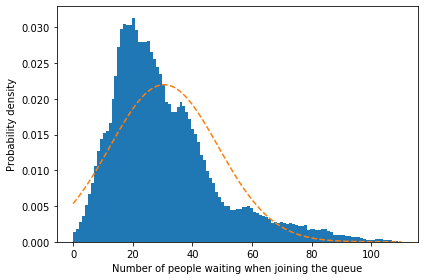

In [8]:
mu = completeDataset["waitingPeople"].mean()  # mean of distribution
sigma = completeDataset["waitingPeople"].std()  # standard deviation of distribution
x = completeDataset["waitingPeople"]

num_bins = 111

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Number of people waiting when joining the queue')
ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
# plt.savefig('./plots/waitingPeopleHistogram.pdf')

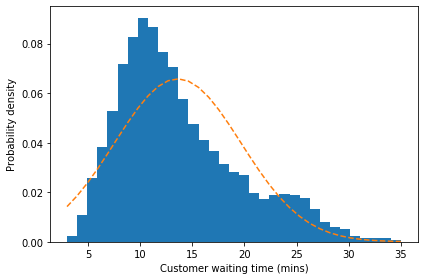

In [9]:
# data to be plotted
mu = completeDataset["waitingTime"].mean()  # mean of distribution
sigma = completeDataset["waitingTime"].std()  # standard deviation of distribution
x = completeDataset["waitingTime"]

num_bins = 33

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Customer waiting time (mins)')
ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()

In [10]:
workingCopyDataset = completeDataset
workingCopyDataset.drop(['serviceTime'], axis=1);

In [11]:
# mean encoding for regression output
def mean_encoder_regression(input_vector, output_vector):
    assert len(input_vector) == len(output_vector)
    numberOfRows = len(input_vector)

    temp = pd.concat([input_vector, output_vector], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=input_vector.name)[output_vector.name].agg(["mean", "count"])
    
    print(averages)
    return_vector = pd.DataFrame(0, index=np.arange(numberOfRows), columns={'feature'})

    
    for i in range(numberOfRows):
        return_vector.iloc[i] = averages['mean'][input_vector.iloc[i]]
        
    return return_vector

In [12]:
encoded_input_vector_hour = mean_encoder_regression(workingCopyDataset['hour'], workingCopyDataset['waitingTime'])
encoded_input_vector_hour.columns = ['hour']
encoded_input_vector_minutes = mean_encoder_regression(workingCopyDataset['minutes'], workingCopyDataset['waitingTime'])
encoded_input_vector_minutes.columns = ['minutes']
encoded_input_vector_dayOfWeek = mean_encoder_regression(workingCopyDataset['dayOfWeek'], workingCopyDataset['waitingTime'])
encoded_input_vector_dayOfWeek.columns = ['dayOfWeek']

           mean  count
hour                  
8     13.415349  11506
9     13.543386   8528
10    13.389851   5774
11    13.839500   5595
12    13.446889   6091
13    13.546714   5630
14    14.167552   7717
              mean  count
minutes                  
0        13.497553   1226
1        13.744149   1239
2        13.718492    849
3        13.720833    960
4        13.970684    921
5        13.467153   1096
6        13.589231    650
7        13.747307   1021
8        13.239157    807
9        13.681598    826
10       13.472356    832
11       13.740385   1144
12       13.771353    761
13       13.473318    862
14       13.843750    800
15       13.715686   1122
16       13.747619    840
17       13.868880   1205
18       13.934605    734
19       13.773643   1290
20       13.536032   1013
21       13.936396    849
22       14.334370    643
23       13.300094   1063
24       13.846547    782
25       13.338156   1106
26       13.908189    806
27       13.550314    954
28       13.9

In [13]:
X = pd.concat([encoded_input_vector_hour['hour'], encoded_input_vector_minutes['minutes'], pd.DataFrame(workingCopyDataset['waitingPeople']), encoded_input_vector_dayOfWeek['dayOfWeek']], axis=1)
y = workingCopyDataset['waitingTime']

In [14]:
X

,hour,minutes,waitingPeople,dayOfWeek
0,13.415349,13.497553,0,13.092387
1,13.415349,13.497553,1,13.092387
2,13.415349,13.497553,2,13.092387
3,13.415349,13.497553,3,13.092387
4,13.415349,13.497553,4,13.092387
...,...,...,...,...
50836,14.167552,13.826406,22,12.815957
50837,14.167552,13.826406,23,12.815957
50838,14.167552,13.993261,23,12.815957
50839,14.167552,12.915900,22,12.815957


In [15]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(40672, 4) (40672,)
(10169, 4) (10169,)


In [16]:
def scale_input(X, means, stds):
    return (X - means) / stds

In [17]:
meansX = trainX.mean(axis=0)
stdsX = trainX.std(axis=0) + 1e-10

In [18]:
trainX_scaled = scale_input(trainX, meansX, stdsX)
testX_scaled = scale_input(testX, meansX, stdsX)

In [19]:
trainX_scaled

,hour,minutes,waitingPeople,dayOfWeek
19060,-0.738627,2.254266,0.356732,0.751511
9683,-0.259424,1.577185,-0.689613,0.751511
14045,-0.246970,0.213726,-0.028763,-0.851344
20736,2.076619,0.336373,-0.414259,-1.303292
19593,-0.620582,-0.361592,-0.359188,0.751511
...,...,...,...,...
11284,2.076619,-1.169327,-1.295391,-1.303292
44732,-0.738627,-1.162249,0.797298,-0.851344
38158,-0.259424,-0.456621,1.017581,1.423101
860,-0.246970,0.124771,-1.130179,-0.851344


In [20]:
inputVariables = 4
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(12, input_dim=inputVariables, kernel_initializer='normal', activation='relu'))
nn_model.add(keras.layers.Dense(8, activation='relu'))
nn_model.add(keras.layers.Dense(4, activation='relu'))
nn_model.add(keras.layers.Dense(1, activation='linear'))
nn_model.summary()

nn_model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [21]:
numberOfEpochs = 500
batchSize = 256
history = nn_model.fit(trainX_scaled, trainy, epochs=numberOfEpochs, batch_size=batchSize, verbose=1, validation_split=0.2)

Train on 32537 samples, validate on 8135 samples
Epoch 1/500
32537/32537 [==============================] - 1s 26us/sample - loss: 12.6488 - val_loss: 10.8374
Epoch 2/500
32537/32537 [==============================] - 0s 6us/sample - loss: 6.6068 - val_loss: 4.0283
Epoch 3/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.9087 - val_loss: 3.8470
Epoch 4/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.8043 - val_loss: 3.7740
Epoch 5/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.7470 - val_loss: 3.7213
Epoch 6/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.7048 - val_loss: 3.6810
Epoch 7/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.6742 - val_loss: 3.6621
Epoch 8/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.6572 - val_loss: 3.6417
Epoch 9/500
32537/32537 [==============================] - 0s 6us/sample - loss: 3.6413 - va

In [22]:
neural_network_predict_test = nn_model.predict(testX_scaled)
neural_network_predict_test

array([[10.118307],
       [10.923872],
       [15.581464],
       ...,
       [12.30162 ],
       [11.524996],
       [10.1324  ]], dtype=float32)

In [23]:
neural_net_mae = mean_absolute_error(neural_network_predict_test,testy)
neural_net_mae

3.5093337908315383

In [24]:
from sklearn.ensemble import RandomForestRegressor

randomForestRegressorModel = RandomForestRegressor(n_estimators=100, random_state=0)
randomForestRegressorModel.fit(trainX_scaled,trainy)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [25]:
random_forest_test_predict = randomForestRegressorModel.predict(testX_scaled)
random_forest_test_predict

array([13.10366667, 10.12666667, 17.51      , ..., 16.95309524,
        8.9047381 , 11.736     ])

In [26]:
random_forest_mae = mean_absolute_error(random_forest_test_predict,testy)
random_forest_mae

3.3399202534769477

In [26]:
from platform import python_version

print(python_version())

3.7.6
